In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

GPU 설정
* 설정 후 , 모델과 데이터에 to로 GPU를 사용 가능한 형태로 변환 해줘야 한다.
* .cuda()로도 가능

* 현재 GPU 설정

In [18]:
torch.cuda.is_available()

False

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [20]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

In [21]:
image, label = next(iter(train_loader))

In [22]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [23]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

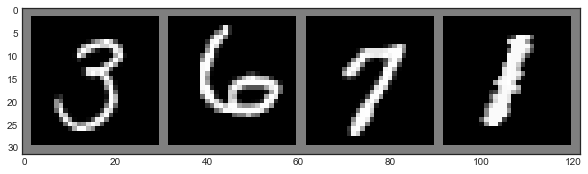

In [24]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [25]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [26]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [30]:
for epoch in range(4):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f'Epoch: {epoch + 1}, Iter: {i + 1}, Loss: {running_loss / 2000}')
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.10571835148334503
Epoch: 1, Iter: 200, Loss: 0.09146058750152587
Epoch: 1, Iter: 300, Loss: 0.06064626243710518
Epoch: 1, Iter: 400, Loss: 0.03851285821199417
Epoch: 2, Iter: 100, Loss: 0.028792301684617997
Epoch: 2, Iter: 200, Loss: 0.0247751187980175
Epoch: 2, Iter: 300, Loss: 0.022711705461144448
Epoch: 2, Iter: 400, Loss: 0.02080076910555363
Epoch: 3, Iter: 100, Loss: 0.017412264093756676
Epoch: 3, Iter: 200, Loss: 0.01576739591360092
Epoch: 3, Iter: 300, Loss: 0.014920930042862893
Epoch: 3, Iter: 400, Loss: 0.013457724548876285
Epoch: 4, Iter: 100, Loss: 0.01282300068438053
Epoch: 4, Iter: 200, Loss: 0.011101346231997013
Epoch: 4, Iter: 300, Loss: 0.010913104627281428
Epoch: 4, Iter: 400, Loss: 0.010256547901779413


In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(100 * correct / total)

94.91
